# Fraud Detection Model Analysis

This notebook analyzes the trained Random Forest model, including performance metrics and SHAP explainability.

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.features.preprocess import load_data

In [4]:
# Load Data and Model
DATA_PATH = '../data/processed/transactions_processed.csv'
MODEL_PATH = '../models/fraud_model.pkl'

X, y = load_data(DATA_PATH)
model = joblib.load(MODEL_PATH)

print("Model and Data Loaded")

Model and Data Loaded


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4568
           1       1.00      0.81      0.89       432

    accuracy                           0.98      5000
   macro avg       0.99      0.90      0.94      5000
weighted avg       0.98      0.98      0.98      5000



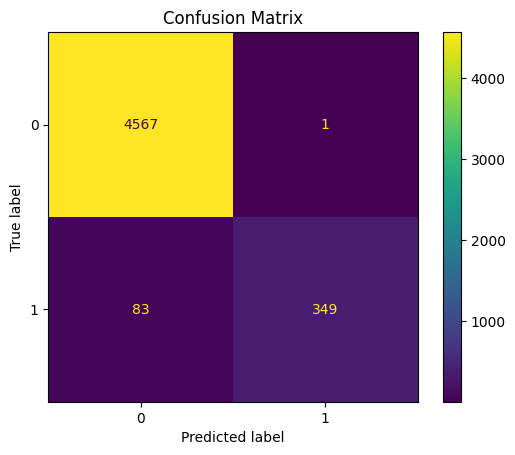

In [5]:
# Model Performance on Full Dataset (for demo purposes)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

## SHAP Explainability
We use SHAP to understand feature importance.

In [6]:
# Prepare data for SHAP
# We need to transform X using the preprocessor part of the pipeline
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']

X_transformed = preprocessor.transform(X)

# Get feature names from preprocessor
feature_names = []
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Fallback if get_feature_names_out is not available or complex
    feature_names = [f'feature_{i}' for i in range(X_transformed.shape[1])]

# Create SHAP explainer
# Using a sample for speed if dataset is large
X_sample = X_transformed[:100] if X_transformed.shape[0] > 100 else X_transformed

# Convert to dense if sparse (SHAP prefers dense for some plots)
if hasattr(X_sample, 'toarray'):
    X_sample = X_sample.toarray()

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_sample)

# Handle different return types of shap_values (list vs array)
if isinstance(shap_values, list):
    # For binary classification, it often returns a list of two arrays [class_0, class_1]
    vals = shap_values[1]
elif isinstance(shap_values, type(np.array([]))) and len(shap_values.shape) == 3:
    # Some versions return (n_samples, n_features, n_classes)
    vals = shap_values[:, :, 1]
else:
    # Binary case returning single array
    vals = shap_values

# Plot
shap.summary_plot(vals, X_sample, feature_names=feature_names)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.